# Book-Crocessing Recommender system project


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import surprise
from surprise.model_selection import GridSearchCV

In [2]:
os.chdir("C:/Users/User_Name/Desktop/data")

Reading the datasets, changing the column names having '-' with '_'

In [3]:
users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1',low_memory=False, na_values=["?"])
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1',low_memory=False)
users.columns = users.columns.str.strip().str.lower().str.replace('-', '_')
ratings.columns = ratings.columns.str.strip().str.lower().str.replace('-', '_')
i_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
books = pd.read_csv('BX-Books.csv', sep=';', names=i_cols, encoding='latin-1',low_memory=False)

Priting the datasets shapes

In [4]:
print(books.shape)
print(users.shape)
print(ratings.shape)

(271380, 8)
(278858, 3)
(1149780, 3)


# Books
Exploring Books dataset

In [5]:
books.head(3)

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
0,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


From the dataset we do not require columns which have image urls, so let us drop them out and view the dataset.

In [6]:
books = books.iloc[1:]
books.drop(columns=['img_s', 'img_m', 'img_l'], inplace=True)
books.head(5)

,isbn,book_title,book_author,year_of_publication,publisher
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
3,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
4,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
5,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


Further exploring 'year_of_publication'

In [7]:
books["year_of_publication"].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', 'John Peterman', '1955',
       '1946', '1936', '1930', '2011', '1925', '1948', '1943', '1947',
       '1945', '1923', '2020', '1939', '1926', '1938', '2030',
       '\\"Freedom Song\\""', '1911', '1904', '1949', 'Frank Muir',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', 'ROBERT A. WILSON', '1933', '1902', 'Karen T. Whittenburg',
       '1924', '1921', '1900', '2038', '2026', 'George H. Scherr', '1944',
       '191

After printing the unique value and analysing the histogram, we find that there are many string, nan and zero values. So, lets convert them the column to numeric value. And, then replace all nan's with zeros and ultimately remove the records with zeros. We also notice that there are values lesser than 1900 and values greater than 2018 books. Let us go ahead and remove the books that were published before 1900 and after 2008.

In [8]:
books["year_of_publication"] = pd.to_numeric(books["year_of_publication"], errors='coerce')

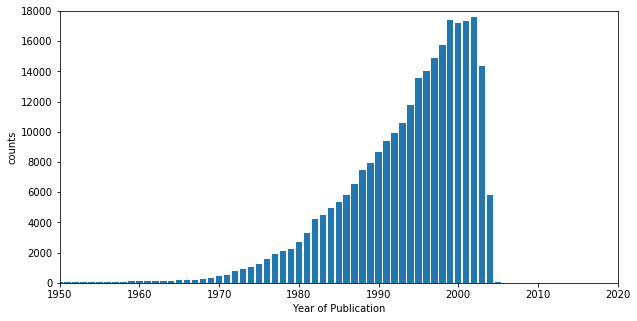

In [9]:
year = books["year_of_publication"].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(year.index, year.values)
plt.axis([1950, 2020, 0, 18000])
plt.xlabel('Year of Publication')
plt.ylabel('counts')
plt.show()

In [10]:
books["year_of_publication"].unique()

array([2002., 2001., 1991., 1999., 2000., 1993., 1996., 1988., 2004.,
       1998., 1994., 2003., 1997., 1983., 1979., 1995., 1982., 1985.,
       1992., 1986., 1978., 1980., 1952., 1987., 1990., 1981., 1989.,
       1984.,    0., 1968., 1961., 1958., 1974., 1976., 1971., 1977.,
       1975., 1965., 1941., 1970., 1962., 1973., 1972., 1960., 1966.,
       1920., 1956., 1959., 1953., 1951., 1942., 1963., 1964., 1969.,
       1954., 1950., 1967., 2005., 1957., 1940., 1937.,   nan, 1955.,
       1946., 1936., 1930., 2011., 1925., 1948., 1943., 1947., 1945.,
       1923., 2020., 1939., 1926., 1938., 2030., 1911., 1904., 1949.,
       1932., 1928., 1929., 1927., 1931., 1914., 2050., 1934., 1910.,
       1933., 1902., 1924., 1921., 1900., 2038., 2026., 1944., 1917.,
       1901., 2010., 1908., 1906., 1935., 1806., 2021., 2012., 2006.,
       1909., 2008., 1378., 1919., 1922., 1897., 2024., 1376., 2037.])

In [11]:
books = books.loc[~(books.isbn.isin(books.isbn[books.year_of_publication<1900]))]
books = books.loc[~(books.isbn.isin(books.isbn[books.year_of_publication>2018]))]

In [12]:
books["year_of_publication"].unique()

array([2002., 2001., 1991., 1999., 2000., 1993., 1996., 1988., 2004.,
       1998., 1994., 2003., 1997., 1983., 1979., 1995., 1982., 1985.,
       1992., 1986., 1978., 1980., 1952., 1987., 1990., 1981., 1989.,
       1984., 1968., 1961., 1958., 1974., 1976., 1971., 1977., 1975.,
       1965., 1941., 1970., 1962., 1973., 1972., 1960., 1966., 1920.,
       1956., 1959., 1953., 1951., 1942., 1963., 1964., 1969., 1954.,
       1950., 1967., 2005., 1957., 1940., 1937.,   nan, 1955., 1946.,
       1936., 1930., 2011., 1925., 1948., 1943., 1947., 1945., 1923.,
       1939., 1926., 1938., 1911., 1904., 1949., 1932., 1928., 1929.,
       1927., 1931., 1914., 1934., 1910., 1933., 1902., 1924., 1921.,
       1900., 1944., 1917., 1901., 2010., 1908., 1906., 1935., 2012.,
       2006., 1909., 2008., 1919., 1922.])

In [13]:
print("Books with zero: ",books[books.year_of_publication == 0].year_of_publication.count())
print("Books with nan: ", books.year_of_publication.isnull().sum())

Books with zero:  0
Books with nan:  22


In [14]:
print("Publisher: ", books.publisher.isnull().sum())
print("isbn: ", books.isbn.isnull().sum())
print("book_title: ", books.isbn.isnull().sum())
print("book_author: ", books.isbn.isnull().sum())

Publisher:  2
isbn:  0
book_title:  0
book_author:  0


In [15]:
books.publisher.replace(np.nan, "Unkown", inplace=True)

In [16]:
print("Publisher: ", books.publisher.isnull().sum())
print("isbn: ", books.isbn.isnull().sum())
print("book_title: ", books.isbn.isnull().sum())
print("book_author: ", books.isbn.isnull().sum())

Publisher:  0
isbn:  0
book_title:  0
book_author:  0


Now, based on the valid dataset, let us see top 10 authors with maximum number of books, maximum number of books with titles,
and publishers with maximum number of books published.

In [17]:
print("Top 10 Authors: \n",books.book_author.value_counts()[:10])

Top 10 Authors: 
 Agatha Christie        598
William Shakespeare    559
Stephen King           511
Ann M. Martin          423
Francine Pascal        372
Carolyn Keene          372
Isaac Asimov           328
Nora Roberts           313
Barbara Cartland       307
Charles Dickens        295
Name: book_author, dtype: int64


In [18]:
print("\nTop 10 Book Titles: \n", books.book_title.value_counts()[:10])


Top 10 Book Titles: 
 Selected Poems                    27
Little Women                      22
Adventures of Huckleberry Finn    20
Dracula                           20
Wuthering Heights                 20
The Night Before Christmas        18
The Secret Garden                 18
Pride and Prejudice               17
Jane Eyre                         16
Masquerade                        16
Name: book_title, dtype: int64


In [19]:
print("\nTop 10 Publishers: \n", books.publisher.value_counts()[:10])


Top 10 Publishers: 
 Harlequin                   7535
Silhouette                  4220
Pocket                      3870
Ballantine Books            3764
Bantam Books                3642
Scholastic                  3156
Simon &amp; Schuster        2965
Penguin Books               2843
Berkley Publishing Group    2767
Penguin USA                 2714
Name: publisher, dtype: int64


On further exploring the book titles we found that there are many books with the same title but published from a different publisher
or a different publishing year. While building the recommending system we have have to make sure we handle this situation.

In [20]:
books[books.book_title=="Little Women"]

,isbn,book_title,book_author,year_of_publication,publisher
3953,185854176X,Little Women,Louisa M. Atcott,1995.0,Brimax Books Ltd
12229,0590203509,Little Women,Louisa May Alcott,1994.0,Scholastic
20678,0440447682,Little Women,Louisa May Alcott,1990.0,Yearling Books
52214,0451529308,Little Women,Louisa May Alcott,2004.0,Signet Classics
52555,0451518144,Little Women,Louisa May Alcott,1983.0,Signet Book
53362,0590437976,Little Women,Louisa May Alcott,1992.0,Scholastic
57436,0195813898,Little Women,Alcott,1985.0,Oxford University Press
72172,0785788727,Little Women,Louisa May Alcott,1999.0,Sagebrush Bound
82569,0448110199,Little Women,Louisa May Alcott,1981.0,Grosset &amp; Dunlap
84811,0812523334,Little Women,Louisa May Alcott,1994.0,Tor Books


# Users

In [21]:
users.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


We see that the whole address is combined into one.Let us separate the data into City, State and Country columns and then 
combine them back together.

In [22]:
user=users[["user_id","age"]]
userLocation = users["location"].str.split(",", n = 2, expand = True)
userLocation.columns=['city', 'state', 'country']
userLocation.isna().sum()

city       0
state      1
country    2
dtype: int64

There are many values with incorrect data in it. Let us fill the empty and NA values as others and proceed ahead.

In [23]:
userLocation.loc[(userLocation.state=='\\n/a\\"') | (userLocation.state=='') | (userLocation.state=='*') | (userLocation.state=='n.a'), ['state']] = 'na'
userLocation.state.fillna('Other', inplace=True)
userLocation.fillna('na', inplace=True)
user=user.join(userLocation)
users = user
users.head(2)

,user_id,age,city,state,country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa


Plotting the histogram, we see that have users whose age is greater than 5 and 100. Let us drop those user records. And, also we will check for NaN, zero and na values and replace with the age mean.

In [24]:
print("Min user's age is: ",users["age"].min())
print("Max user's age is: ",users["age"].max())

Min user's age is:  0.0
Max user's age is:  244.0


In [25]:
print("Users with 5 > age & age > 99 :",users.loc[(user.age>99) | (user.age<5),'age'].count())

Users with 5 > age & age > 99 : 1255


In [26]:
user.loc[(user.age>99) | (user.age<5),'age'] = np.nan
print(users.user_id[users.age.isnull()].count())
users.age.fillna(round(users.age.mean(),2), axis=0, inplace=True)

112017


In [27]:
print(users.user_id[users.age.isnull()].count())

0


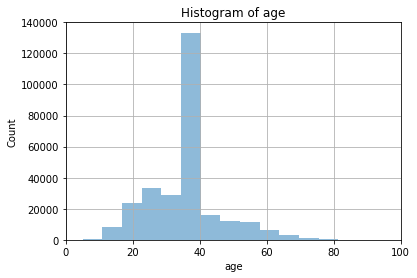

In [28]:
plt.hist(users["age"], bins=16, alpha=0.5)
plt.xlabel('age')
plt.ylabel('Count')
plt.title('Histogram of age')
plt.axis([0, 100, 0, 140000])
plt.grid(True)

Now, with the remaining users let us calculate the top 5 countries with maximum users, check the distribution of users across different cities and the repeat the same steps with country.

In [29]:
top_cities = users.city.value_counts()[:5]
print("Top cities from which most of the users are:\n", top_cities)

Top cities from which most of the users are:
 london       4105
barcelona    2664
toronto      2342
madrid       1933
sydney       1884
Name: city, dtype: int64


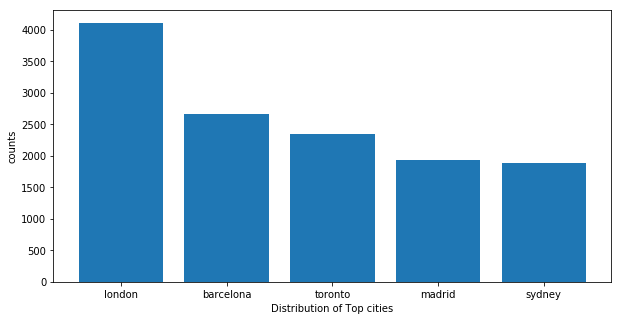

In [30]:
plt.figure(figsize=(10, 5))
plt.bar(top_cities.index, top_cities.values)
plt.xlabel('Distribution of Top cities')
plt.ylabel('counts')
plt.show()

In [31]:
top_countries = users.country.value_counts()[:10]
print("Top countries from which most of the users are:\n", top_countries)

Top countries from which most of the users are:
  usa               139183
 canada             21556
 united kingdom     18286
 germany            17021
 spain              13088
 australia          11719
 italy              11238
                     4561
 france              3440
 portugal            3305
Name: country, dtype: int64


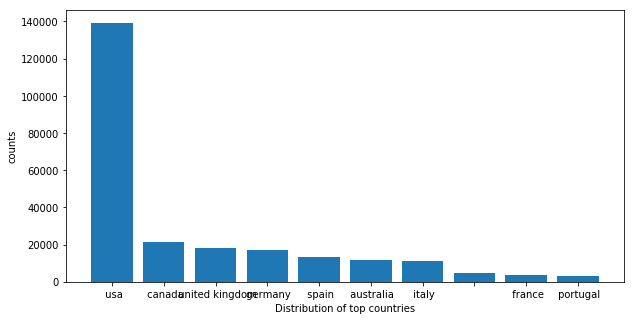

In [32]:
plt.figure(figsize=(10, 5))
plt.bar(top_countries.index, top_countries.values)
plt.xlabel('Distribution of top countries')
plt.ylabel('counts')
plt.show()

# Ratings

In [33]:
ratings.head(5)

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [34]:
ratings.shape

(1149780, 3)

Checking the number of users in the data per book. Remember we still have not removed our multiple isbn problem.

In [35]:
superUsers = ratings.groupby('user_id').isbn.count().sort_values(ascending=False)
print(superUsers.size)

105283


Let us now consider the books that are available to us in our books dataset and users only whose information we have with us. This done because we simply cannot recommend books without any information. 

In [36]:
ratings_new=ratings[ratings.isbn.isin(books.isbn)]
ratings_new=ratings_new[ratings_new.user_id.isin(users.user_id)]
print(ratings.shape)
print(ratings_new.shape)
ratings =ratings_new

(1149780, 3)
(1017096, 3)


Our main attribute here in this table is the rating table. Plotting it on a bar chart shows us that there are manu books that are rated zero than the other ratings. And, a rating zero books has no value to our evaluation. So, let us drop those recods.

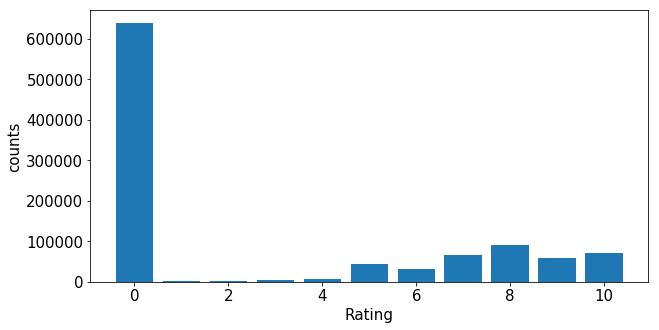

In [37]:
rtg = ratings.book_rating.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.show()

In [38]:
ratings = ratings[ratings.book_rating != 0]

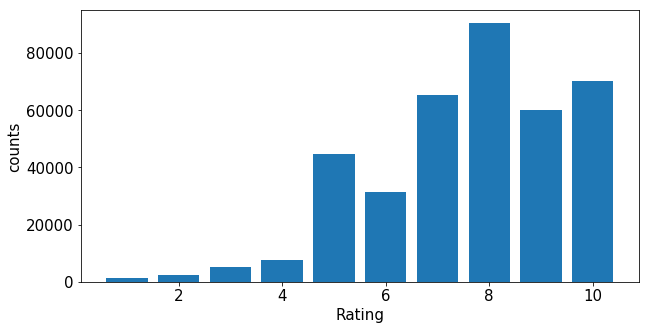

In [39]:
rtg = ratings.book_rating.value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15}) 
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.show()

The dataset that we currently have is huge and inorder not to run into memory error we have further scrutinized our dataset by removing users who have not rated minimum  of 100 books.

In [40]:
n1 = ratings["user_id"].value_counts()
ratings = ratings[ratings['user_id'].isin(n1[n1 >= 100].index)]
n2 = ratings["book_rating"].value_counts()
ratings = ratings[ratings['book_rating'].isin(n2[n2 >= 100].index)]

In [41]:
ratings.shape

(101121, 3)

Now, let's combine book and rating dataset based on their ISBN bumbers and store into a new dataset called RESULT

In [42]:
result = pd.merge(books, ratings, how='right', on=['isbn', 'isbn'])
result

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,11676,8
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,110912,10
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,197659,9
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,11676,9
4,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,46398,9
5,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,230522,7
6,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,245827,9
7,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,52614,8
8,0671870432,PLEADING GUILTY,Scott Turow,1993.0,Audioworks,11676,8
9,0440234743,The Testament,John Grisham,1999.0,Dell,7346,9


We have aware of the problem, a single book having mutiple isbn number just because they were either released by a different publisher or it is a different version. We must consider such book as a single unique book. For this first we have identified books with same title and grouped them together and then selected first book's occurance ISBN and assigned its ISBN to other versions of the book.

In [43]:
books_multiple_isbns = result.groupby('book_title').isbn.nunique()
books_multiple_isbns.value_counts()

1     56521
2      2962
3       512
4       134
5        49
6        14
7         9
8         5
11        1
9         1
Name: isbn, dtype: int64

In [44]:
has_multiple_isbns = books_multiple_isbns.where(books_multiple_isbns>1)
has_multiple_isbns.dropna(inplace=True)
has_multiple_isbns['Little Women']

6.0

In [45]:
def isbn_dict(df):
    dict_title_isbn = {}
    for title in has_multiple_isbns.index:
        isbn_series = df.loc[df.book_title==title].isbn.unique()
        dict_title_isbn[title] = isbn_series.tolist()
    return dict_title_isbn
%time dict_unique_isbn = isbn_dict(result)

with open('isbn_dict.pickle', 'wb') as handle:
    pickle.dump(dict_unique_isbn, handle, protocol=pickle.HIGHEST_PROTOCOL)

Wall time: 34.1 s


In [46]:
with open('isbn_dict.pickle', 'rb') as handle:
    isbn_dict = pickle.load(handle)

In [47]:
def unique_isbn_col(df):
    df['unique_isbn'] = df.apply(lambda row: isbn_dict[row.book_title][0] if row.book_title in isbn_dict.keys() else row.isbn, axis=1)
    return df
%time result = unique_isbn_col(result)

Wall time: 2.32 s


In [48]:
result[result.book_title=='Little Women'].head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating,unique_isbn
22320,0590203509,Little Women,Louisa May Alcott,1994.0,Scholastic,147847,5,0590203509
22321,0590203509,Little Women,Louisa May Alcott,1994.0,Scholastic,184532,10,0590203509
51104,0451529308,Little Women,Louisa May Alcott,2004.0,Signet Classics,274301,10,0590203509
51270,0451518144,Little Women,Louisa May Alcott,1983.0,Signet Book,251843,10,0590203509
59181,0785788727,Little Women,Louisa May Alcott,1999.0,Sagebrush Bound,36907,10,0590203509


Dropping duplicate values to create the matrix

In [49]:
items_wo_duplicates = result.drop_duplicates(['book_title', 'unique_isbn'])

# MEMORY BASED APPROACH

Now, let's create a matrix with user_id as rows and columns as unique_isbn. By this we get a matrix which is similar to our DT matrix. And, build a memory based approach and make top 10 recommendation.

In [50]:
ratings_mat = items_wo_duplicates.pivot(index = "user_id", columns ="unique_isbn", values = "book_rating" )
user = ratings_mat.index
ISBN = ratings_mat.columns

In [51]:
print(ratings_mat.shape)

(438, 60208)


In [52]:
ratings_mat.fillna(0, inplace=True)

In [53]:
from sklearn import neighbors
from sklearn.neighbors import NearestNeighbors

In [54]:
def sim(user_id,ratings, k):
    """This function calculates the similarity"""
    sim = []
    dist = []
    knnclf = NearestNeighbors(algorithm = "brute",metric='euclidean')
    knnclf.fit(ratings)
    loc = ratings.index.get_loc(user_id)    
    dist, index = knnclf.kneighbors(ratings.iloc[loc,:].values.reshape(1, -1), n_neighbors = k+1)
    sim = 1 - dist.flatten()    
    return sim, index

In [55]:
def prediction(user_id, ratings, item, k):
    """using the above similarity matrix, we predict the item similar to the user"""
    predict = 0
    user = ratings.index.get_loc(user_id)
    item = ratings.columns.get_loc(item)
    similarity, index = sim(user_id, ratings, k)
    mean_ratings = ratings.iloc[user,:].mean()
    total = np.sum(similarity)-1
    product = 1
    wt_sum = 0
    for i in range(0, len(index.flatten())):
        if index.flatten()[i]==user: continue
        else:
            rating_diff = ratings.iloc[index.flatten()[i],item] - np.mean(ratings.iloc[index.flatten()[i],:])
            product = rating_diff * similarity[i]
            wt_sum += product
    
    if predict> 10: predict = 10
    elif predict <= 0: predict = 0
    predict = int(round(mean_ratings + (wt_sum/total)))
    #print(user_id, item, predict)
    return predict

In [56]:
def recommend(user_id, ratings, k):
    """Function we recommend items to user by calculating the similarity and predicting the item."""
    predict = []
    for i in range(ratings.shape[1]):
        if(ratings[str(ratings.columns[i])][user_id]!=0):
            predict.append(prediction(user_id, ratings, str(ratings.columns[i]),k))
        else:
            predict.append(-1)
    predict = pd.Series(predict)
    predict = predict.sort_values(ascending = False)
    recommendation = predict[:10]
    for i in range(len(recommendation)):
        print(books.book_title[recommendation.index[i]])
    return recommendation

In [57]:
#Simple top - N recommendation using memory based approach
recommendation = recommend(60337, ratings_mat, 5)

Tales of the Sacred and the Supernatural
Women With Attention Deficit Disorder: Embracing Disorganization at Home and in the Workplace
Frindle
Philosophischer Versuch Ã?Â¼ber die Wahrscheinlichkeit.
Sternenflut. Roman.
The Life of Mahatma Gandhi (Harper colophon books)
Oxygen
To Meet Again
Satellite Sisters' Uncommon Senses
The Little Engine That Could ABC (Wee Pudgy Board Books)


# MODEL BASED APPROACH

In this approach, we use the package called surprise module which is suggested to be used for building SVD and NMF models. We divide the the whole dataset into training and testing data using Hold out evaluation (80% - 20%). Get unique values for user and books, create a matrix for them based on ratings. Build the three models based on the user. Calculate Precision and recall values. Choose a model with best precision value as our final model and build a recommeder system based on user id.

In [58]:
books_users_ratings = pd.merge(users, result, how='right', on=['user_id', 'user_id'])

In [79]:
uir = books_users_ratings[['user_id','unique_isbn','book_rating']]
uir.head(5)

,user_id,unique_isbn,book_rating
0,2033,0142000663,10
1,2033,0836218256,9
2,2033,0030020786,7
3,2033,0133502813,10
4,2033,0716724022,7


In [60]:
uir_ex = uir
b_unique = uir_ex.unique_isbn.unique()  # create a 'set' (i.e. all unique) list of vals
book2idx = {o:i for i, o in enumerate(b_unique)}
uir_ex['b_unique'] = uir_ex['unique_isbn'].map(book2idx)
uir_ex_x = uir_ex[['user_id', 'b_unique']]
uir_ex_y =uir_ex[['book_rating']]

C:\Users\Rakshit\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [61]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
#divide the data into train and test
X_train, X_test, y_train, y_test = train_test_split(uir_ex_x, uir_ex_y, test_size=.2, random_state=221)

In [62]:
#SVM model building
classifier = svm.LinearSVC(random_state=221)
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)
pred = classifier.predict(X_test)
print(accuracy_score(y_test, pred))
precision_recall_fscore_support(y_test, pred, average='macro')

C:\Users\Rakshit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.18017305315203955


C:\Users\Rakshit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.029663678686006816, 0.10320074957524958, 0.03853277033437108, None)

In [80]:
from surprise import Reader, Dataset, SVD, NMF, model_selection, accuracy
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(uir, reader)

We run model based alogrithms on our data set, SVD and NMF. Out of both the best precision algorithm will be choosen as final model.

In [81]:
modelList=[SVD(),NMF()]
trainset, testset = model_selection.train_test_split(data, test_size=0.2)
for mod in modelList:
    model = mod
    model.fit(trainset)
    predictions = model.test(testset)
    accuracy.rmse(predictions)
    accuracy.mae(predictions)

RMSE: 1.4712
MAE:  1.1063
RMSE: 2.4061
MAE:  2.0036


In [82]:
param_grid = {'n_factors': [80, 100, 120], 'lr_all': [0.001, 0.005, 0.01], 'reg_all': [0.01, 0.02, 0.04]}
gridSearch = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gridSearch.fit(data)

In [68]:
model = gridSearch.best_estimator['rmse']
print(gridSearch.best_score['rmse'])
print(gridSearch.best_params['rmse'])

1.4982246262633117
{'n_factors': 100, 'lr_all': 0.005, 'reg_all': 0.04}


In [69]:
finalModel = SVD(n_factors=80, lr_all=0.005, reg_all=0.04)
finalModel.fit(trainset)
test_pred = finalModel.test(testset)
accuracy.rmse(test_pred, verbose=True)

RMSE: 1.4852


1.4852117327229604

Checking the validity, by predicting for a user and checking the predicted and actual rating

In [67]:
uid = 277427
iid = str('0060006641')
pred = finalModel.predict(uid,iid, verbose=True)

user: 277427     item: 0060006641 r_ui = None   est = 8.86   {'was_impossible': False}


In [68]:
print(f'Estimated rating for the book - "unique_isbn" isbn {pred.iid} from user #{pred.uid} is {pred.est:.2f}.\n')
actual_rating = uir[(uir.user_id==pred.uid) & (uir.unique_isbn==pred.iid)].book_rating.values[0]
print(f'The real rating given for this was {actual_rating:.2f}.')

Estimated rating for the book - "unique_isbn" isbn 0060006641 from user #277427 is 8.86.

The real rating given for this was 10.00.


In [70]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """This function creates a list of top 10 recommended items"""
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

based on the final model we predict and get the top n recommendation

In [71]:
pred = finalModel.test(testset)
top_n = get_top_n(pred)

In [72]:
def get_reading_list(userid):
    """This function returns the recommended reading list by calculating the top 10 books"""
    reading_list = defaultdict(list)
    top_n = get_top_n(predictions, n=10)
    for n in top_n[userid]:
        book, rating = n
        title = result.loc[result.unique_isbn==book].book_title.unique()[0]
        reading_list[title] = rating
    return reading_list

Final based on the books recommended let us recommend the user - 60337 with our top 10 books and also display their ratings

In [73]:
example_reading_list = get_reading_list(userid=60337)
print("{:<80} | {:<5}".format("Book Titles","Rating"))
print("--------------------------------------------------------------------------------------------")
for book, rating in example_reading_list.items():
    print("{:<80} | {:<5}".format(book, round(rating,2)))

Book Titles                                                                      | Rating
--------------------------------------------------------------------------------------------
The Life I Lead: A Novel                                                         | 7.82 
A FEW MINUTES WITH ANDY ROONEY                                                   | 7.82 
GOING TO MEET THE MAN                                                            | 7.82 
James Baldwin:American Writer, lives of notable gay men and lesbians             | 7.82 
Taking Care of Mrs. Carroll (Stonewall Inn Editions)                             | 7.82 
My Mama's Dead Squirrel: Lesbian Essays on Southern Culture                      | 7.82 
Virtually Normal: An Argument About Homosexuality                                | 7.82 
The Price of the Ticket : Collected Nonfiction, 1948-1985                        | 7.82 
Understanding Literature: An Introduction to Reading and Writing                 | 7.82 
The Secret of Ro